In [1]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import pandas as pd

2023-08-08 18:09:13.928383: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 18:09:13.929957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 18:09:13.960337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 18:09:13.961204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 18:09:14.705497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
dat1 =pd.read_csv('synthetic_Brusselator_data.csv')
dat1.head()

,# t,z1,z2
0,0.00000,1.000000,-1.000000
1,0.03003,0.904262,-0.902779
2,0.06006,0.824295,-0.818702
3,0.09009,0.756687,-0.744775
4,0.12012,0.698984,-0.678877


In [3]:
z1_data = np.array(dat1["z1"]).flatten()[:,None]
z2_data = np.array(dat1["z2"]).flatten()[:,None]
t_data = np.array(dat1["# t"]).flatten()[:,None]

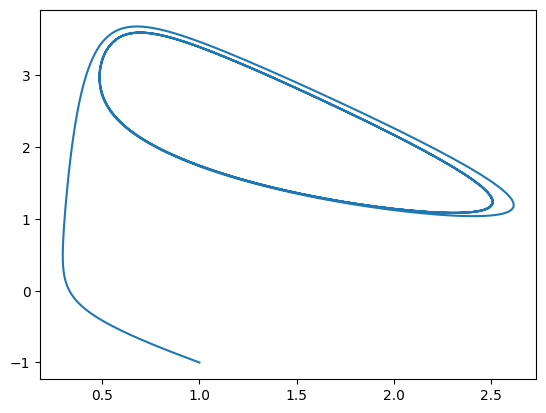

In [4]:
plt.plot(z1_data,z2_data,"-")
plt.show()

2023-08-08 18:09:16.179693: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


32/32 [==============================] - 0s 470us/step
Estimated parameters: k1 = 1.0038480, k2 = 2.5088659
Computed parameters: k1 = 1.0038480, k2 = 2.5088659
Computational time: 981.8078200817108 seconds


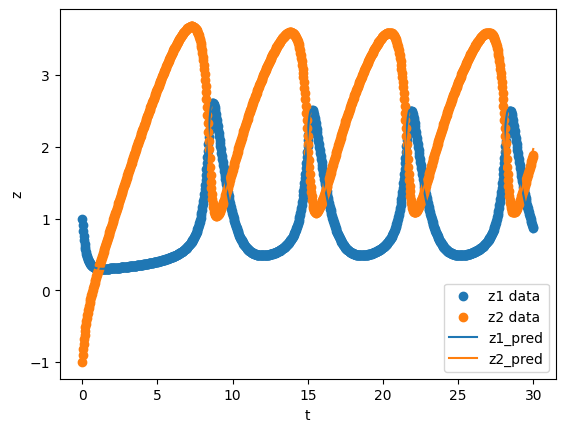

In [5]:
u1_u2 = np.hstack((z1_data, z2_data)) # Combining z1 and z2
t_data = np.squeeze(t_data)


# Start the timer
start_time = time.time()


#Updated architecture
architecture = [1, 64, 64, 64, 2]  # One input layer, three hidden layers with 40 neurons each, and one output layer

# Define the updated model
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='tanh', input_shape=(1,)))  # First hidden layer
model.add(layers.Dense(64, activation='tanh'))  # Second hidden layer
model.add(layers.Dense(64, activation='tanh'))  # Third hidden layer
model.add(layers.Dense(2))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(t_data, u1_u2, epochs=50000, verbose=0)

# Define the system of differential equations
def system(u, t, k1, k2):
    du1_dt = k1 + u[0]**2*u[1] - (k2 + 1)*u[0]
    du2_dt = k2 * u[0] - u[0]**2 * u[1]
    return [du1_dt, du2_dt]


initial_conditions = u1_u2[0] # Assuming the initial conditions are the first data points


# Define the function to solve the non-linear system
def solve_nonlinear_system(p):
    u = odeint(system, initial_conditions, t_data, args=tuple(p))
    return np.sum(u, axis=0) - np.sum(model.predict(t_data), axis=0)


# Initial guess for the parameters
initial_guess = [1, 1]


# Use fsolve to solve the non-linear system
k1, k2 = fsolve(solve_nonlinear_system, initial_guess)

print(f"Estimated parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")


# Stop the timer
end_time = time.time()

# Compute the computational time
comp_time = end_time - start_time

print(f"Computed parameters: k1 = {k1:.7f}, k2 = {k2:.7f}")
print(f"Computational time: {comp_time} seconds")

# Generate more points for a smoother plot
t_fine = np.linspace(t_data.min(), t_data.max(), 1000)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Plot the original data
plt.scatter(t_data, u1_u2[:, 0], label='z1 data')
plt.scatter(t_data, u1_u2[:, 1], label='z2 data')

# Plot the fitted curves
plt.plot(t_fine, u_fine[:, 0], label='z1_pred')
plt.plot(t_fine, u_fine[:, 1], label='z2_pred')

plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.show()

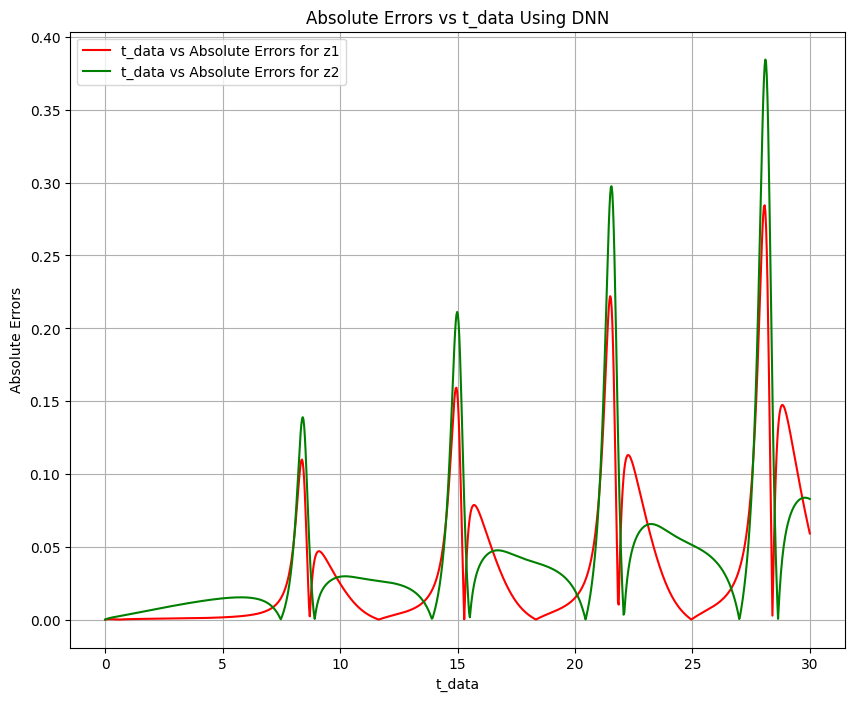

In [6]:
# Generate more points for a smoother plot
t_fine = np.linspace(0, 1, 1000)
u_fine = odeint(system, initial_conditions, t_fine, args=(k1, k2))

# Generate points for original t values
u_pred = odeint(system, initial_conditions, t_data, args=(k1, k2))


# plot the absolute errors between the target and the predictions (make sure u1_u2 and t are defined properly)
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data, np.abs(u1_u2[:, 0] - u_pred[:, 0]), 'r')
plt.plot(t_data, np.abs(u1_u2[:, 1] - u_pred[:, 1]), 'g')
plt.xlabel('t_data')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for z1", "t_data vs Absolute Errors for z2"])
plt.grid(True)
plt.title("Absolute Errors vs t_data Using DNN")
plt.show()


In [7]:
# calculate the R-squared
from sklearn.metrics import r2_score
r2_u1 = r2_score(u1_u2[:, 0], u_pred[:, 0])
r2_u2 = r2_score(u1_u2[:, 1], u_pred[:, 1])
print(f"R-squared for u1: {r2_u1}")
print(f"R-squared for u2: {r2_u2}")

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_u1 = mean_absolute_error(u1_u2[:, 0], u_pred[:, 0])
mae_u2 = mean_absolute_error(u1_u2[:, 1], u_pred[:, 1])
print(f"Mean absolute error for u1: {mae_u1}")
print(f"Mean absolute error for u2: {mae_u2}")

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_u1 = mean_squared_error(u1_u2[:, 0], u_pred[:, 0])
mse_u2 = mean_squared_error(u1_u2[:, 1], u_pred[:, 1])
print(f"Mean squared error for u1: {mse_u1}")
print(f"Mean squared error for u2: {mse_u2}")

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_u1 = mean_squared_error(u1_u2[:, 0], u_pred[:, 0], squared=False)
rmse_u2 = mean_squared_error(u1_u2[:, 1], u_pred[:, 1], squared=False)
print(f"Root mean squared error for u1: {rmse_u1}")
print(f"Root mean squared error for u2: {rmse_u2}")

# calculate the Explained variance score
from sklearn.metrics import explained_variance_score
evs_u1 = explained_variance_score(u1_u2[:, 0], u_pred[:, 0])
evs_u2 = explained_variance_score(u1_u2[:, 1], u_pred[:, 1])
print(f"Explained variance score for u1: {evs_u1}")
print(f"Explained variance score for u2: {evs_u2}")


R-squared for u1: 0.9902828314605386
R-squared for u2: 0.99480243462893
Mean absolute error for u1: 0.036029580875062465
Mean absolute error for u2: 0.045508175415627974
Mean squared error for u1: 0.003840557644184257
Mean squared error for u2: 0.005494070930212819
Root mean squared error for u1: 0.061972232848141406
Root mean squared error for u2: 0.07412200031173484
Explained variance score for u1: 0.9903060030698473
Explained variance score for u2: 0.9948025676126759
